In [8]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical
import random
import cv2
import os

In [9]:
def plot(x, p=None, labels=False):
    plt.figure(figsize=(20,2))
    for i in range(10): # refers to the first 10 images that we are plotting
        plt.subplot(1, 10, i+1) # 1 row and 10 columns; the index for the subplot 
        plt.imshow(x[i].reshape(28, 28), # this will show the image except we will have to reshape to 28 by 28 because we flattened it in the previous task.
                   cmap = 'binary') # "binary" so that we see the black and white images as they are.
        plt.xticks([])
        plt.yticks([])
        if labels: # if labels is true,
            plt.xlabel(np.argmax(p[i])) # then we also want to label our X axis.
    plt.show()
    return

# Stap 1: importeer de images
#### - De afbeeldingen met ruis
#### - De afbeeldingen zonder ruis
Zorg dat de afbeeldingen:
- In greyscale staan
- De afbeeldingen genormaliseerd zijn (0-1)
- De shape (len(dataset),28,28) is
- Tip, je kan de dataset visualiseren met de plot functie, hierboven gedefinieerd

In [14]:
# 1. Bepaal je basisfolder (relatief of absoluut)
import os
cwd = os.getcwd()
# Optie A: automatisch gebaseerd op werkmap
base_dir = os.path.join(cwd)
# Optie B: handmatig aanpassen aan jouw omgeving
# base_dir = r"C:\full\path\to\Smart Industry\College 4\image denoise les"

undistorted_dir = os.path.join(base_dir, "undistorted_images")
distorted_dir   = os.path.join(base_dir, "distorted_images")

In [15]:
# 2. Debug: print paden en mapinhoud
print("Current working directory:", cwd)
print("Inhoud cwd:", os.listdir(cwd))
print("Constructed base_dir:", base_dir)
print("Inhoud base_dir:", os.listdir(base_dir) if os.path.isdir(base_dir) else "[niet gevonden]")

Current working directory: c:\GitHub\Smart_Industry\Smart Industry\College 4\image denoise les
Inhoud cwd: ['.ipynb_checkpoints', 'Autoencoders image denoising - les 4 Marius.ipynb', 'Autoencoders image denoising - les 4.ipynb', 'distorted_images', 'undistorted_images']
Constructed base_dir: c:\GitHub\Smart_Industry\Smart Industry\College 4\image denoise les
Inhoud base_dir: ['.ipynb_checkpoints', 'Autoencoders image denoising - les 4 Marius.ipynb', 'Autoencoders image denoising - les 4.ipynb', 'distorted_images', 'undistorted_images']


In [16]:
# 3. Functie om afbeeldingen in te laden uit een map
def load_images_from_folder(folder_path):
    images = []
    for fname in sorted(os.listdir(folder_path)):
        fpath = os.path.join(folder_path, fname)
        if os.path.isfile(fpath):
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, (28, 28))
            img_norm = img_resized.astype('float32') / 255.0
            images.append(img_norm)
    return np.array(images)

In [17]:
# 4. Laad de datasets
x_clean = load_images_from_folder(undistorted_dir)
x_noisy = load_images_from_folder(distorted_dir)

In [18]:
# 5. Controleer shapes en waardenbereik
print(f"Clean data shape:  {x_clean.shape}, range: [%.3f, %.3f]" % (x_clean.min(), x_clean.max()))
print(f"Noisy data shape:  {x_noisy.shape}, range: [%.3f, %.3f]" % (x_noisy.min(), x_noisy.max()))

Clean data shape:  (2762, 28, 28), range: [0.000, 1.000]
Noisy data shape:  (10, 28, 28), range: [0.000, 1.000]


Eerste 10 verstoorde (noisy) beelden:


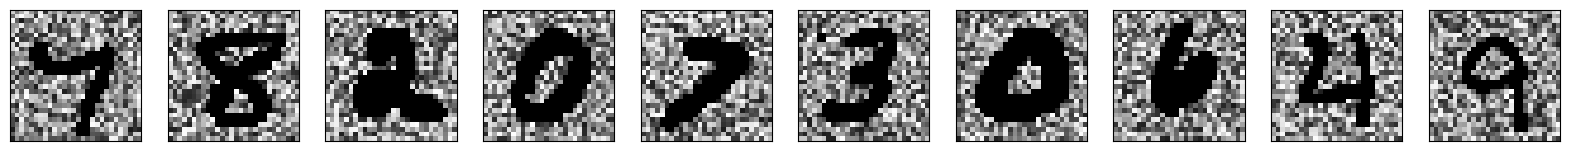

Eerste 10 ongestoorde (clean) beelden:


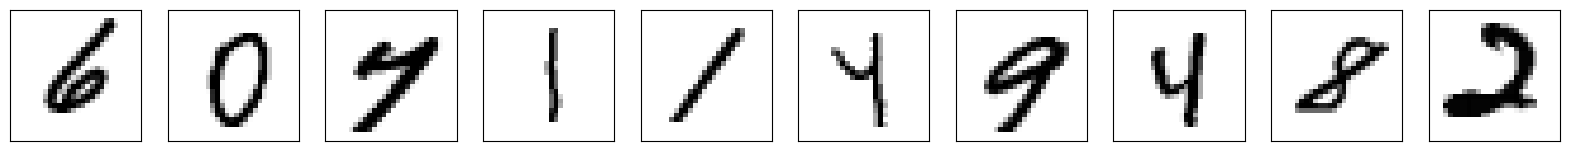

In [19]:
# 6. Visualiseer de eerste 10 afbeeldingen
print("Eerste 10 verstoorde (noisy) beelden:")
plot(x_noisy)
print("Eerste 10 ongestoorde (clean) beelden:")
plot(x_clean)

# Stap 2: Voeg noise toe
- Voeg ruis toe aan de afbeeldingen, zoek zelf uit hoe je dit moet doen
- kijk of het goed is gegaan door de ruis te vergelijken met de gekregen afbeeldingen met ruis

In [20]:
# 7. Voeg zelf Gaussian noise toe aan de clean-set
noise_factor = 0.5
np.random.seed(42)  # voor reproduceerbaarheid
x_synth_noisy = x_clean + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_clean.shape)
# Clip om binnen [0,1] te blijven
x_synth_noisy = np.clip(x_synth_noisy, 0., 1.)
print(f"Synth. noisy shape: {x_synth_noisy.shape}, range: [{x_synth_noisy.min():.3f}, {x_synth_noisy.max():.3f}]")

Synth. noisy shape: (2762, 28, 28), range: [0.000, 1.000]


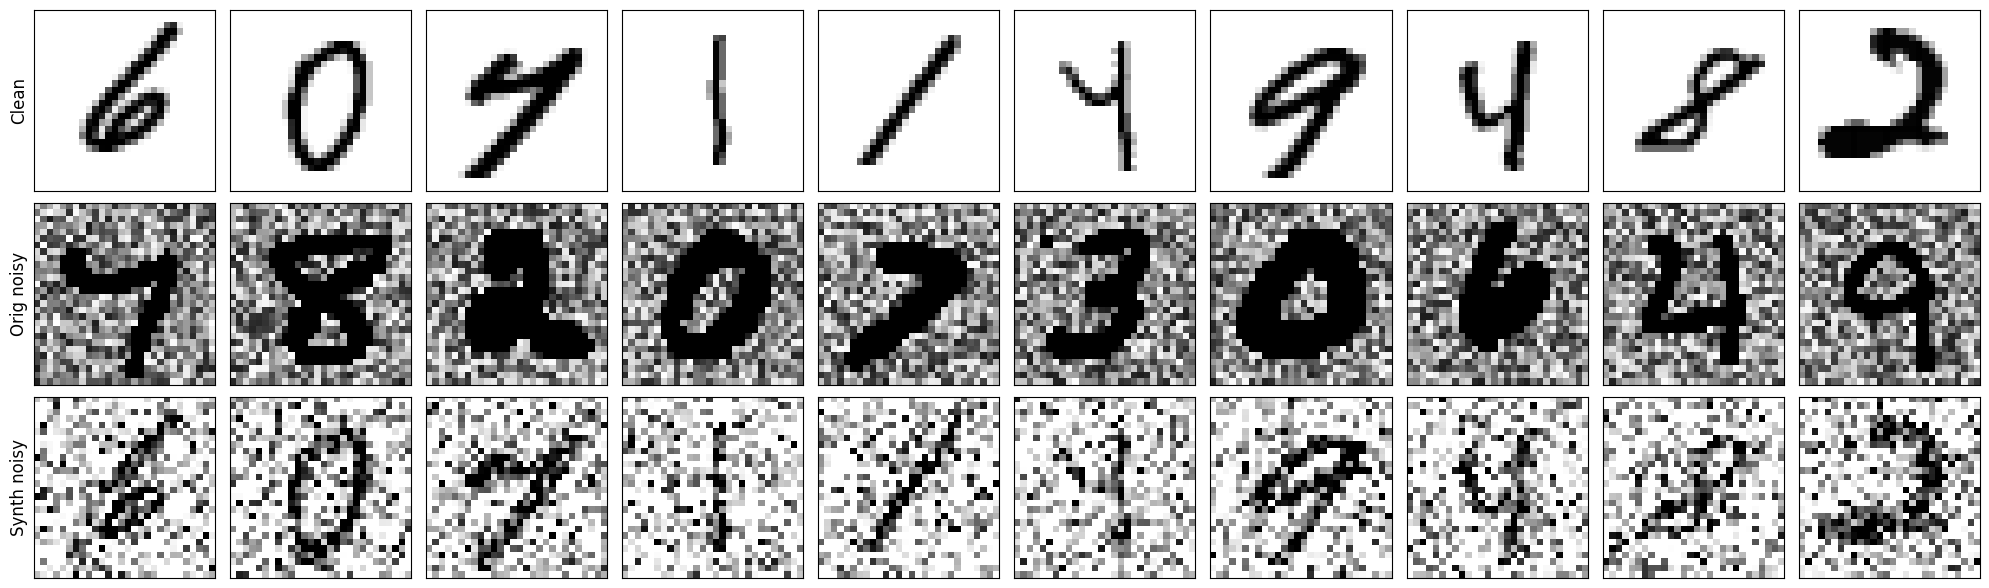

In [21]:
# 8. Vergelijk synthetische ruis met de originele ruis
# Plot eerste 10 op elke rij: clean, echte noisy, synthetische noisy
def compare_noise(clean, real_noisy, synth_noisy):
    plt.figure(figsize=(20, 6))
    for i in range(10):
        # Clean
        plt.subplot(3, 10, i+1)
        plt.imshow(clean[i].reshape(28,28), cmap='binary')
        plt.xticks([]); plt.yticks([])
        if i == 0: plt.ylabel('Clean', size=12)
        # Originele noisy
        plt.subplot(3, 10, 10 + i+1)
        plt.imshow(real_noisy[i].reshape(28,28), cmap='binary')
        plt.xticks([]); plt.yticks([])
        if i == 0: plt.ylabel('Orig noisy', size=12)
        # Synth noisy
        plt.subplot(3, 10, 20 + i+1)
        plt.imshow(synth_noisy[i].reshape(28,28), cmap='binary')
        plt.xticks([]); plt.yticks([])
        if i == 0: plt.ylabel('Synth noisy', size=12)
    plt.tight_layout()
    plt.show()

compare_noise(x_clean, x_noisy, x_synth_noisy)

# Stap 3: Train de autoencoder
- Hieronder heb ik een model gedefinieerd die jullie gaan gebruiken
- Voordat je het model kan trainen moet je de shape van de dataset in 2d zetten, gebruik hiervoor de reshape functie van numpy
- De nieuwe shape moet (len(dataset), 784) zijn
- Train vervolgens de dataset

In [22]:
def train_autoencoder(X_train_noisy, X_train):
    """
    Deze functie heeft 2 datasets nodig, de afbeeldingen met ruis en die zonder ruis,
    De functie geeft de getrainde autoencoder, en print de training loss.
    
    de .predict methode kan gebruikt worden om de predictions te krijgen
    
    """
    input_image = Input(shape=(784,))
    encoded = Dense(64, activation='relu')(input_image)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input_image, decoded)
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
    autoencoder.fit(
        X_train_noisy, X_train, 
        epochs=100,
        batch_size=512, 
        validation_split=0.2, # Use a validation split of 20%,
        verbose=False, # set verbose to false because we don't want to actually use any build logs. 
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5),
            LambdaCallback(on_epoch_end=lambda e,l: print('{:.4f}'.format(l['val_loss']), end=' _ '))
        ]
    )
    print(' _ ')
    print('Training is complete!')
    return autoencoder

In [23]:
# 3.1 Reshape naar (n_samples, 784)
X_train = x_clean.reshape((x_clean.shape[0], -1))
X_train_noisy = x_synth_noisy.reshape((x_synth_noisy.shape[0], -1))
print(f"Reshaped X_train: {X_train.shape}, X_train_noisy: {X_train_noisy.shape}")

Reshaped X_train: (2762, 784), X_train_noisy: (2762, 784)


In [24]:
# 3.2 Definieer en train de autoencoder
def train_autoencoder(X_train_noisy, X_train):
    from tensorflow.keras.layers import Dense, Input
    from tensorflow.keras.models import Model
    from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

    input_image = Input(shape=(784,))
    encoded = Dense(64, activation='relu')(input_image)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input_image, decoded)
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
    print("Training autoencoder...")
    autoencoder.fit(
        X_train_noisy, X_train, 
        epochs=100,
        batch_size=512, 
        validation_split=0.2,
        verbose=False,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5),
            LambdaCallback(on_epoch_end=lambda e,l: print(f"Epoch {e+1}: val_loss={l['val_loss']:.4f}"))
        ]
    )
    print('Training is complete!')
    return autoencoder

In [25]:
# 3.3 Train en sla model op
autoencoder = train_autoencoder(X_train_noisy, X_train)

Training autoencoder...
Epoch 1: val_loss=0.6442
Epoch 2: val_loss=0.5192
Epoch 3: val_loss=0.3794
Epoch 4: val_loss=0.3055
Epoch 5: val_loss=0.2816
Epoch 6: val_loss=0.2744
Epoch 7: val_loss=0.2712
Epoch 8: val_loss=0.2688
Epoch 9: val_loss=0.2663
Epoch 10: val_loss=0.2647
Epoch 11: val_loss=0.2633
Epoch 12: val_loss=0.2621
Epoch 13: val_loss=0.2611
Epoch 14: val_loss=0.2597
Epoch 15: val_loss=0.2584
Epoch 16: val_loss=0.2564
Epoch 17: val_loss=0.2543
Epoch 18: val_loss=0.2519
Epoch 19: val_loss=0.2493
Epoch 20: val_loss=0.2464
Epoch 21: val_loss=0.2431
Epoch 22: val_loss=0.2398
Epoch 23: val_loss=0.2364
Epoch 24: val_loss=0.2329
Epoch 25: val_loss=0.2297
Epoch 26: val_loss=0.2263
Epoch 27: val_loss=0.2231
Epoch 28: val_loss=0.2198
Epoch 29: val_loss=0.2168
Epoch 30: val_loss=0.2140
Epoch 31: val_loss=0.2112
Epoch 32: val_loss=0.2087
Epoch 33: val_loss=0.2063
Epoch 34: val_loss=0.2041
Epoch 35: val_loss=0.2023
Epoch 36: val_loss=0.2000
Epoch 37: val_loss=0.1983
Epoch 38: val_loss=0.19

# Stap 3: Predictions
- Haal nu de ruis weg bij de gekregen afbeeldingen met ruis
- Zet eerst de afbeeldingen om naar 2d
- Stop ze daarna in het model
- Zet daarna de output weer terug naar 3d
- kijk of de ruis goed is weggehaald

In [26]:
# 3.4 Reshape de originele noisy afbeeldingen naar 2D
X_real_noisy = x_noisy.reshape((x_noisy.shape[0], -1))
print(f"Reshaped X_real_noisy: {X_real_noisy.shape}")

Reshaped X_real_noisy: (10, 784)


In [27]:
# 3.5 Voer predictions uit (denoising)
X_denoised_flat = autoencoder.predict(X_real_noisy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [28]:
# 3.6 Zet de output terug naar 3D (n_samples, 28, 28)
x_denoised = X_denoised_flat.reshape((x_noisy.shape[0], 28, 28))
print(f"Denoised data shape: {x_denoised.shape}, range: [%.3f, %.3f]" % (x_denoised.min(), x_denoised.max()))

Denoised data shape: (10, 28, 28), range: [0.000, 0.842]


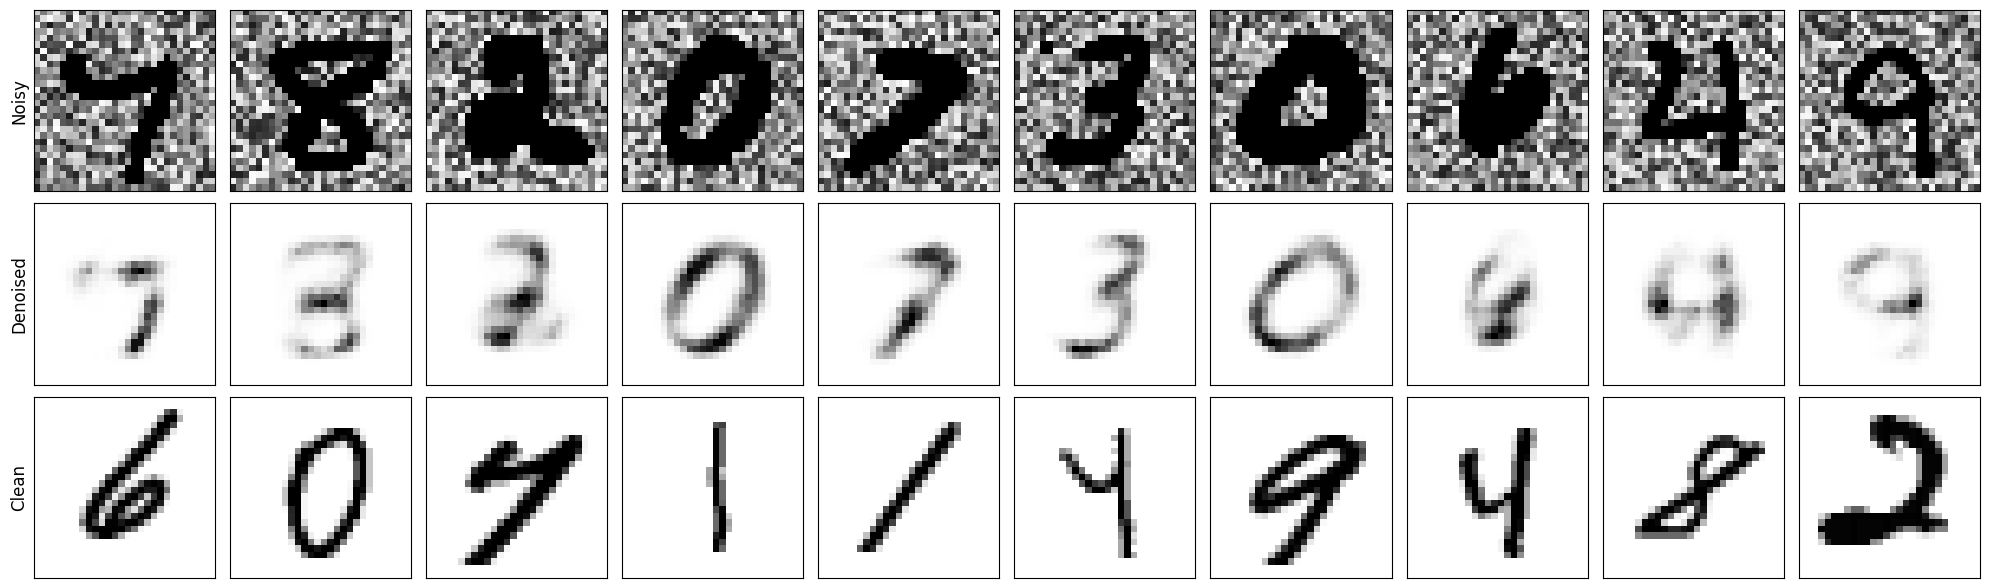

In [29]:
# 3.7 Visualiseer enkele resultaten
def visualize_denoising(clean, noisy, denoised, num=10):
    plt.figure(figsize=(20, 6))
    for i in range(num):
        # Noisy input
        plt.subplot(3, num, i+1)
        plt.imshow(noisy[i].reshape(28,28), cmap='binary')
        plt.xticks([]); plt.yticks([])
        if i == 0: plt.ylabel('Noisy', size=12)
        # Denoised output
        plt.subplot(3, num, num + i+1)
        plt.imshow(denoised[i].reshape(28,28), cmap='binary')
        plt.xticks([]); plt.yticks([])
        if i == 0: plt.ylabel('Denoised', size=12)
        # Clean ground truth
        plt.subplot(3, num, 2*num + i+1)
        plt.imshow(clean[i].reshape(28,28), cmap='binary')
        plt.xticks([]); plt.yticks([])
        if i == 0: plt.ylabel('Clean', size=12)
    plt.tight_layout()
    plt.show()

visualize_denoising(x_clean, x_noisy, x_denoised, num=10)